<a href="https://colab.research.google.com/github/austin-leung/whos-that-pokemon/blob/master/pokemonMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Who's That Pokémon?

A multilayer perceptron neural network trained to identify Pokémon

![alt text](https://i.ytimg.com/vi/09saU1wbuBo/maxresdefault.jpg)

---

### Integrating Google Colab with Google Drive

I decided to use Google Colab for this project as it gives me access to GPU power to run my machine learning model. I learned how to download datasets into Google Colab from the following article: https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166. 

Here, I mount the drive to Google Colab and then upload the files and upload the kaggle.json file connecting to my kaggle account's API key. This allows me to access files in my drive from this Jupyter Notebook file. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import files
files.upload()

### Download Images from Kaggle


I found a wonderful dataset of handpicked images of the over 928 currently released Pokémon (with their various forms) uploaded onto Kaggle (https://www.kaggle.com/mrgravelord/complete-pokemon-image-dataset). There are 15-50 images of each Pokémon.

I create the folder path for the kaggle.json file.

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

The dataset of images is downloaded to my Google Drive directory in a folder called pkmnDataset and then unzipped.

In [0]:
!kaggle datasets download -d mrgravelord/complete-pokemon-image-dataset -p /content/drive/My\ Drive/pkmnDataset

In [0]:
import os
!unzip -q /content/drive/My\ Drive/pkmnDataset/complete-pokemon-image-dataset.zip -d /content/drive/My\ Drive/pkmnImgs

### Load Training and Testing Data

Much of the following code is graciously borrowed from Udacity's Intro to Deep Learning course! Check more of it out here https://www.udacity.com/course/deep-learning-pytorch--ud188. 

Now using PyTorch, I download the training data, making sure to transform the images to grayscale and resize them to a standard processable size of 160x160. The grayscale reduces the complexity of the model as this is only a simple linear neural network. 

80% of the images are used as a training set and 20% of the images are used as a testing set in order to prevent overfitting.

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms

from torch import optim

import matplotlib.pyplot as plt

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])

# resize all images to 160x160 and grayscale
trainTransform  = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((160, 160)),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.5,), (0.5,))])

# percentage of training set to use as testing
test_size = 0.2

# Download and load the data
imgData = datasets.ImageFolder('/content/drive/My Drive/pkmnImgsSubset', transform=trainTransform)

# obtain training indices that will be used for training and testing datasets
num_train = len(imgData)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

# define samplers for obtaining training and test batches
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

# We take 64 images per batch
trainloader = torch.utils.data.DataLoader(imgData, batch_size=64, 
                                          sampler=train_sampler)
testloader = torch.utils.data.DataLoader(imgData, batch_size=64, 
                                           sampler=test_sampler)


### Visualize an Image

Before I define and run my model, I create a dictionary so that I know which numerical label corresponds to which Pokémon later. I also view an image I have downloaded to make sure everything is as I expect, including size and grayscale.


torch.Size([64, 1, 160, 160])
{0: 'Abomasnow', 1: 'Abra', 2: 'Absol', 3: 'Accelgor', 4: 'Aegislash', 5: 'Aerodactyl', 6: 'Aggron', 7: 'Aipom', 8: 'Alakazam', 9: 'Alomomola'}
Absol


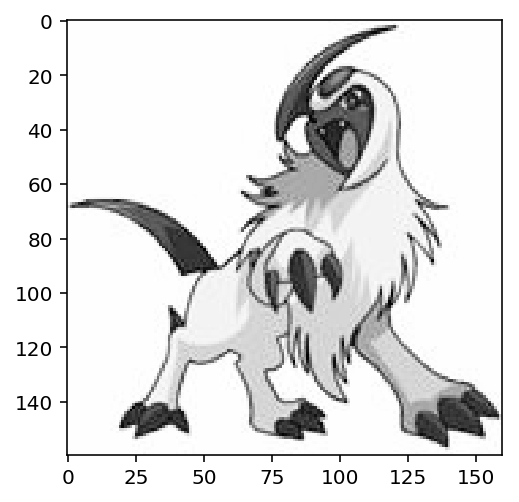

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape) # make sure tensor is as I expect

# create a dictionary mapping labels to pokemon
pkmnIndDict = imgData.class_to_idx
pkmnIndDict = dict((v,k) for k,v in pkmnIndDict.items()) # flip keys and values
print(pkmnIndDict)

# view the 9th imaage in the batch to verify it is correct
print(pkmnIndDict[labels[9].item()])
plt.imshow(images[9].numpy().squeeze(), cmap='Greys_r')

### Define and Train the Model

I finally define my sequential model here. I use a linear neural network with a hard-tanh activation function as I found the best results with it (having tried others like ReLu). For my loss function I use categorical cross-entropy and I use stochastic gradient descent with a learning rate of 0.01 for my optimizer.

In [0]:
images, labels = next(iter(trainloader))
print(images.shape)
images.resize_(images.shape[0], 25600)
print(images.shape) # image tensor has been flattened


model = nn.Sequential(nn.Linear(25600, 128),
                      nn.Hardtanh(-1, 1),
                      nn.Linear(128, 10),
                      nn.LogSoftmax(dim=1))

# loss function
criterion = nn.NLLLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 50
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten images into a 25600 long vector
        images = images.view(images.shape[0], -1)

        optimizer.zero_grad() # initialize everything to 0
        output = model(images) # run the sequential model
        loss = criterion(output, labels) # calculate loss
        loss.backward() # backpropagate, changing weights
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")


torch.Size([64, 1, 160, 160])
torch.Size([64, 25600])
Training loss: 2.4752107858657837
Training loss: 2.0546946227550507
Training loss: 1.9049816131591797
Training loss: 1.8635706901550293
Training loss: 1.6154898703098297
Training loss: 1.5193943977355957
Training loss: 1.4930170178413391
Training loss: 1.3520192801952362
Training loss: 1.355321079492569
Training loss: 1.3326869010925293
Training loss: 1.2293202877044678
Training loss: 1.0842537730932236
Training loss: 1.085855320096016
Training loss: 1.0824849605560303
Training loss: 0.9568834602832794
Training loss: 0.949456661939621
Training loss: 0.849173977971077
Training loss: 0.8504781126976013
Training loss: 0.8324805349111557
Training loss: 0.7570347338914871
Training loss: 0.6571015119552612
Training loss: 0.7101666629314423
Training loss: 0.6007715910673141
Training loss: 0.6079350560903549
Training loss: 0.5664663538336754
Training loss: 0.577947773039341
Training loss: 0.49424733221530914
Training loss: 0.475742593407630

### Test the Model

Finally, I visualize the probability of a given image being each Pokémon according to my trained model using my testing dataset!


Actual Pokémon: Abomasnow
Predicted Pokémon: Abomasnow 86.2%
9: Alomomola
8: Alakazam
7: Aipom
6: Aggron
5: Aerodactyl
4: Aegislash
3: Accelgor
2: Absol
1: Abra
0: Abomasnow


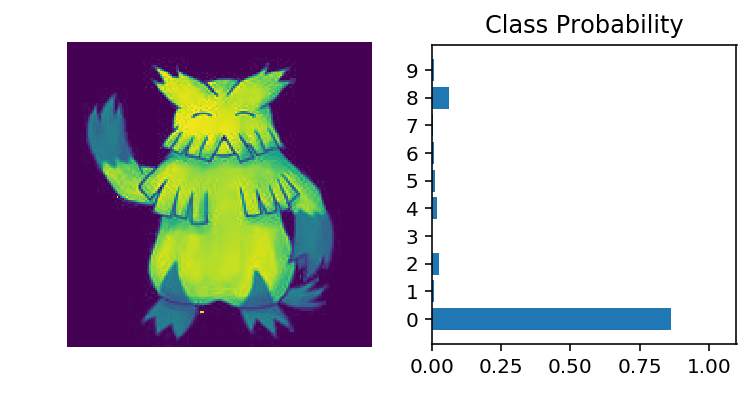

In [0]:
%matplotlib inline
import helper

def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 160, 160).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

# grab the next image from the test dataset
images, labels = next(iter(testloader))

img = images[0].view(1, 25600)
print("Actual Pokémon:", pkmnIndDict[labels[0].item()])
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
print("Predicted Pokémon:", 
      pkmnIndDict[np.argmax(ps).item()], 
      str(round(torch.max(ps).item() * 100.0, 1)) + "%")
for i in range(9, -1, -1):
  print(str(i) + ":", pkmnIndDict[i])
view_classify(img.view(1, 160, 160), ps)